In [1]:
import os

import copy

import pickle

import time

import numpy as np
import pandas as pd

import sys
sys.path.append(r'../')

from utils.WilmanDB import *
from utils.spectrum import *
from utils.methods import skymodel_to_img
from utils.methods import check_mem
import utils.methods as mthd
from utils.functions import in_FoV


from utils.galaxy import RSgen

import matplotlib.pyplot as plt


from astropy import convolution
from astropy.io import fits as fits
import astropy.units as u
from radio_beam import Beam

from scipy.ndimage.interpolation import shift
from scipy.signal import fftconvolve

from joblib import Parallel, delayed


In [2]:
def get_nonzero_values(arr, lim=0):
    indices = np.nonzero(arr > lim)
    return np.transpose((indices[0], indices[1], arr[indices]))

def normalize(arr, flux):
    return arr * flux / np.sum(arr)

In [3]:
def read_skymodel(fn):
    pickle_open = open(fn, 'rb')
    skymodel_151 = pickle.load(pickle_open)
    pickle_open.close()
    return skymodel_151

def save_skymodel(fn, skymodel):
    pickle_skymodel = open( fn, 'wb' )
    pickle.dump( skymodel, pickle_skymodel )
    pickle_skymodel.close()
    
def skymodel_to_img_allsky2(skymodel, img_size, box=None):
    w, h = img_size
    img = np.zeros([w, h])
    if box == None:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            for i in range(len(x)):
                img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img
    else:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            if in_FoV(box[0], box[1], x, y):
                for i in range(len(x)):
                    img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img[box[0]:box[1], box[0]:box[1]]
    
def skymodel_to_img_allsky2(skymodel, img_size, box=None):
    w, h = img_size
    img = np.zeros([w, h])
    if box == None:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            for i in range(len(x)):
                img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img
    else:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            if in_FoV(box[0], box[1], x, y):
                for i in range(len(x)):
                    img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img[box[0]:box[1], box[0]:box[1]]
    

def skymodel_to_img_allsky(skymodel, img_size, box=None):
    w, h = img_size
    img = np.zeros([w, h])
    out_skymodel = []
    if box == None:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            for i in range(len(x)):
                img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img
    else:
        for source in skymodel:
            if 'type' in source.keys():
                if source['type'] == 'FR1' or source['type'] == 'FR2':
                    x = source['data'][:, 0] + source['core_x'] - source['relative_x']
                    y = source['data'][:, 1] + source['core_y'] - source['relative_y']
                else:
                    x = source['data'][:, 0] + source['x'] - source['relative_x']
                    y = source['data'][:, 1] + source['y'] - source['relative_y']
            else:
                x = source['data'][:, 0] + source['x'] - source['relative_x']
                y = source['data'][:, 1] + source['y'] - source['relative_y']
            if in_FoV(box[0], box[1], x, y):
                out_skymodel.append(source)
                for i in range(len(x)):
                    img[int(x[i]), int(y[i])] += source['data'][i, 2]
        return img[box[0]:box[1], box[0]:box[1]], out_skymodel
    
def skymodel_to_img_single_source(skymodel, img_size):
    w, h = img_size
    img = np.zeros([w, h])
    x = skymodel[:, 0]
    y = skymodel[:, 1]
    for i in range(len(x)):
        img[int(x[i]), int(y[i])] += skymodel[i, 2]
    return img

def sim_multifreq(simulated_freqs, inputmodel):
    """
    *** sim_multifreq() generate multi-frequency skymodel from the 151 MHz skymodel ***
    :Params simulated_freqs: input ndarray;
    :Params skymodel: 151 MHz skymodel from Simulate();
    :Output multi_skymodel: multifrequency skymodel | dict;
    """    
    multi_skymodel = {}
    for freq_i in simulated_freqs:
        skymodel_i = []
        freq = freq_i #MHz
        print(freq)
        for i in range(len(inputmodel)):
            source = copy.deepcopy(inputmodel[i])
            source['sim_freq'] = freq
            if 'type' in source.keys():
                if source['type'] == 'RQ':
                    source['data'][:, 2] = rqq_spec(source['data'][:, 2], freq)
                if source['type'] == 'FR1':
                    source['core_data'][:, 2] = fr1_core_spec(source['core_data'][:, 2], freq)
                    source['lobe1_data'][:, 2] = fr1_lobe_spec(source['lobe1_data'][:, 2], freq)
                    source['lobe2_data'][:, 2] = fr1_lobe_spec(source['lobe2_data'][:, 2], freq)
                    img_w = int(np.max(source['data'][:, 0]))+1
                    img_h = int(np.max(source['data'][:, 1]))+1
                    img_core = skymodel_to_img_single_source(source['core_data'], [img_w, img_h])
                    img_lobe1 = skymodel_to_img_single_source(source['lobe1_data'], [img_w, img_h])
                    img_lobe2 = skymodel_to_img_single_source(source['lobe2_data'], [img_w, img_h])
                    img = img_core + img_lobe1 + img_lobe2
                    source['data'] = get_nonzero_values(img)
                if source['type'] == 'FR2':
                    source['core_data'][:, 2] = fr2_core_spec(source['core_data'][:, 2], freq)
                    source['lobe1_data'][:, 2] = fr2_lobe_spec(source['lobe1_data'][:, 2], freq)
                    source['lobe2_data'][:, 2] = fr2_hotspot_spec(source['lobe2_data'][:, 2], freq)
                    source['hotspot1_data'][:, 2] = fr2_hotspot_spec(source['hotspot1_data'][:, 2], freq)
                    source['hotspot2_data'][:, 2] = fr2_hotspot_spec(source['hotspot2_data'][:, 2], freq)
                    img_w = int(np.max(source['data'][:, 0]))+1
                    img_h = int(np.max(source['data'][:, 1]))+1
                    img_core = skymodel_to_img_single_source(source['core_data'], [img_w, img_h])
                    img_lobe1 = skymodel_to_img_single_source(source['lobe1_data'], [img_w, img_h])
                    img_lobe2 = skymodel_to_img_single_source(source['lobe2_data'], [img_w, img_h])
                    img_hp1 = skymodel_to_img_single_source(source['hotspot1_data'], [img_w, img_h])
                    img_hp2 = skymodel_to_img_single_source(source['hotspot2_data'], [img_w, img_h])       
                    img = img_core + img_lobe1 + img_lobe2 + img_hp1 + img_hp2
                    source['data'] = get_nonzero_values(img)
                if source['type'] == 'SF':
                    source['data'][:, 2] = sf_spec(source['data'][:, 2], freq)
                if source['type'] == 'SB':
                    source['data'][:, 2] = sb_spec(source['data'][:, 2], freq)
            else:
                if source['sftype'] == 4:
                    source['data'][:, 2] = sf_spec(source['data'][:, 2], freq)
                if source['sftype'] == 5:
                    source['data'][:, 2] = sb_spec(source['data'][:, 2], freq)
            skymodel_i.append(source)
        multi_skymodel[str(freq_i)] = skymodel_i
    return multi_skymodel

In [4]:
PARAMS, fr1_skymodel = read_skymodel('skymodel_GMM_151_fr1_08_24_all_v2.pkl')
_, fr2_skymodel = read_skymodel('skymodel_GMM_151_fr2_08_24_all_v2.pkl')
_, rq_skymodel = read_skymodel('skymodel_GMM_151_rq_08_23.pkl')
_, sf_skymodel = read_skymodel('skymodel_GMM_151_sf_08_23.pkl')
_, sb_skymodel = read_skymodel('skymodel_GMM_151_sb_08_23.pkl')

In [5]:
img_fr1_4deg, skymodel_fr1_4deg = skymodel_to_img_allsky(fr1_skymodel, [7200, 7200], [0, 7200])
#img_fr1_2deg, skymodel_fr1_2deg = skymodel_to_img_allsky(fr1_skymodel, [7200, 7200], [1800, 5400])
img_fr2_4deg, skymodel_fr2_4deg = skymodel_to_img_allsky(fr2_skymodel, [7200, 7200], [0, 7200])
#img_fr2_2deg, skymodel_fr2_2deg = skymodel_to_img_allsky(fr2_skymodel, [7200, 7200], [1800, 5400])
img_rq_4deg, skymodel_rq_4deg = skymodel_to_img_allsky(rq_skymodel, [7200, 7200], [0, 7200])
#img_rq_2deg, skymodel_rq_2deg = skymodel_to_img_allsky(rq_skymodel, [7200, 7200], [1800, 5400])
img_sb_4deg, skymodel_sb_4deg = skymodel_to_img_allsky(sb_skymodel, [7200, 7200], [0, 7200])
#img_sb_2deg, skymodel_sb_2deg = skymodel_to_img_allsky(sb_skymodel, [7200, 7200], [1800, 5400])
img_sf_4deg, skymodel_sf_4deg = skymodel_to_img_allsky(sf_skymodel, [7200, 7200], [0, 7200])
#img_sf_2deg, skymodel_sf_2deg = skymodel_to_img_allsky(sf_skymodel, [7200, 7200], [1800, 5400])

In [7]:
save_skymodel('skymodel_fr1_4deg_all_v2.pkl', skymodel_fr1_4deg)
#save_skymodel('skymodel_fr1_2deg_all_v2.pkl', skymodel_fr1_2deg)
save_skymodel('skymodel_fr2_4deg_all_v2.pkl', skymodel_fr2_4deg)
#save_skymodel('skymodel_fr2_2deg_all_v2.pkl', skymodel_fr2_2deg)
save_skymodel('skymodel_rq_4deg_all_v2.pkl', skymodel_rq_4deg)
#save_skymodel('skymodel_rq_2deg_all_v2.pkl', skymodel_rq_2deg)
save_skymodel('skymodel_sf_4deg_all_v2.pkl', skymodel_sf_4deg)
#save_skymodel('skymodel_sf_2deg_all_v2.pkl', skymodel_sf_2deg)
save_skymodel('skymodel_sb_4deg_all_v2.pkl', skymodel_sb_4deg)
#save_skymodel('skymodel_sb_2deg_all_v2.pkl', skymodel_sb_2deg)

In [5]:
# skymodel_fr1_4deg = read_skymodel('skymodel_fr1_4deg.pkl')
# skymodel_fr1_2deg = read_skymodel('skymodel_fr1_2deg.pkl')
# skymodel_fr2_4deg = read_skymodel('skymodel_fr2_4deg.pkl')
# skymodel_fr2_2deg = read_skymodel('skymodel_fr2_2deg.pkl')
# skymodel_rq_4deg = read_skymodel('skymodel_rq_4deg.pkl')
# skymodel_rq_2deg = read_skymodel('skymodel_rq_2deg.pkl')
# skymodel_sf_4deg = read_skymodel('skymodel_sf_4deg.pkl')
# skymodel_sf_2deg = read_skymodel('skymodel_sf_2deg.pkl')
# skymodel_sb_4deg = read_skymodel('skymodel_sb_4deg.pkl')
# skymodel_sb_2deg = read_skymodel('skymodel_sb_2deg.pkl')
skymodel_fr1_4deg = read_skymodel('skymodel_fr1_4deg_all_v2.pkl')
skymodel_fr1_2deg = read_skymodel('skymodel_fr1_2deg_all_v2.pkl')
skymodel_fr2_4deg = read_skymodel('skymodel_fr2_4deg_all_v2.pkl')
skymodel_fr2_2deg = read_skymodel('skymodel_fr2_2deg_all_v2.pkl')
skymodel_rq_4deg = read_skymodel('skymodel_rq_4deg_all_v2.pkl')
skymodel_rq_2deg = read_skymodel('skymodel_rq_2deg_all_v2.pkl')
skymodel_sf_4deg = read_skymodel('skymodel_sf_4deg_all_v2.pkl')
skymodel_sf_2deg = read_skymodel('skymodel_sf_2deg_all_v2.pkl')
skymodel_sb_4deg = read_skymodel('skymodel_sb_4deg_all_v2.pkl')
skymodel_sb_2deg = read_skymodel('skymodel_sb_2deg_all_v2.pkl')

In [8]:
simulated_freqs_low = np.linspace(120, 128, 51)
simulated_freqs_mid = np.linspace(154, 162, 51)
simulated_freqs_hig = np.linspace(188, 196, 51)

In [9]:
all_types_skymodel_4deg = skymodel_fr1_4deg + skymodel_fr2_4deg + skymodel_rq_4deg + skymodel_sb_4deg + skymodel_sf_4deg
#all_types_skymodel_2deg = skymodel_fr1_2deg + skymodel_fr2_2deg + skymodel_rq_2deg + skymodel_sb_2deg + skymodel_sf_2deg

In [10]:
def writetofitsK(prefix, img_Jy, pix_area, freq, img_size):
    JytoTb = calc_Tb(1, pix_area, freq)
    img_all_sky_K = img_Jy * JytoTb
    fitsname = prefix + '%.2f.fits' %(freq)
    header = fits.Header()
    header['IMGSIZE'] = img_size
    print(fitsname)
    fits.writeto(fitsname, data=img_all_sky_K, header=header, overwrite=True)

In [12]:
len(skymodel_fr1_4deg)

789340

In [ ]:
inputmodel = copy.deepcopy(all_types_skymodel_2deg)
for freq in simulated_freqs_low:
    skymodel_low_freqi_2deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_2deg[str(freq)], [7200, 7200], [1800, 5400])
    prefix = '../results/evaluation_data/eva_ptr_FoV2_low_'
    writetofitsK(prefix, img, 4, freq, 3600)

for freq in simulated_freqs_mid:
    skymodel_low_freqi_2deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_2deg[str(freq)], [7200, 7200], [1800, 5400])
    prefix = '../results/evaluation_data/eva_ptr_FoV2_mid_'
    writetofitsK(prefix, img, 4, freq, 3600)
    
for freq in simulated_freqs_hig:
    skymodel_low_freqi_2deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_2deg[str(freq)], [7200, 7200], [1800, 5400])
    prefix = '../results/evaluation_data/eva_ptr_FoV2_hig_'
    writetofitsK(prefix, img, 4, freq, 3600)

120.0


In [13]:
inputmodel = copy.deepcopy(all_types_skymodel_4deg)
for freq in simulated_freqs_low:
    skymodel_low_freqi_4deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_4deg[str(freq)], [7200, 7200])
    prefix = '../results/evaluation_data/eva_ptr_FoV4_low_'
    writetofitsK(prefix, img, 4, freq, 7200)

for freq in simulated_freqs_mid:
    skymodel_low_freqi_4deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_4deg[str(freq)], [7200, 7200])
    prefix = '../results/evaluation_data/eva_ptr_FoV4_mid_'
    writetofitsK(prefix, img, 4, freq, 7200)
    
for freq in simulated_freqs_hig:
    skymodel_low_freqi_4deg = sim_multifreq([freq], inputmodel)
    img = skymodel_to_img_allsky2(skymodel_low_freqi_4deg[str(freq)], [7200, 7200])
    prefix = '../results/evaluation_data/eva_ptr_FoV4_hig_'
    writetofitsK(prefix, img, 4, freq, 7200)

120.0
../results/evaluation_data/eva_ptr_FoV4_low_120.00.fits
120.16
../results/evaluation_data/eva_ptr_FoV4_low_120.16.fits
120.32
../results/evaluation_data/eva_ptr_FoV4_low_120.32.fits
120.48
../results/evaluation_data/eva_ptr_FoV4_low_120.48.fits
120.64
../results/evaluation_data/eva_ptr_FoV4_low_120.64.fits
120.8
../results/evaluation_data/eva_ptr_FoV4_low_120.80.fits
120.96
../results/evaluation_data/eva_ptr_FoV4_low_120.96.fits
121.12
../results/evaluation_data/eva_ptr_FoV4_low_121.12.fits
121.28
../results/evaluation_data/eva_ptr_FoV4_low_121.28.fits
121.44
../results/evaluation_data/eva_ptr_FoV4_low_121.44.fits
121.6
../results/evaluation_data/eva_ptr_FoV4_low_121.60.fits
121.76
../results/evaluation_data/eva_ptr_FoV4_low_121.76.fits
121.92
../results/evaluation_data/eva_ptr_FoV4_low_121.92.fits
122.08
../results/evaluation_data/eva_ptr_FoV4_low_122.08.fits
122.24
../results/evaluation_data/eva_ptr_FoV4_low_122.24.fits
122.4
../results/evaluation_data/eva_ptr_FoV4_low_122.40.f

192.64
../results/evaluation_data/eva_ptr_FoV4_hig_192.64.fits
192.8
../results/evaluation_data/eva_ptr_FoV4_hig_192.80.fits
192.96
../results/evaluation_data/eva_ptr_FoV4_hig_192.96.fits
193.12
../results/evaluation_data/eva_ptr_FoV4_hig_193.12.fits
193.28
../results/evaluation_data/eva_ptr_FoV4_hig_193.28.fits
193.44
../results/evaluation_data/eva_ptr_FoV4_hig_193.44.fits
193.6
../results/evaluation_data/eva_ptr_FoV4_hig_193.60.fits
193.76
../results/evaluation_data/eva_ptr_FoV4_hig_193.76.fits
193.92
../results/evaluation_data/eva_ptr_FoV4_hig_193.92.fits
194.08
../results/evaluation_data/eva_ptr_FoV4_hig_194.08.fits
194.24
../results/evaluation_data/eva_ptr_FoV4_hig_194.24.fits
194.4
../results/evaluation_data/eva_ptr_FoV4_hig_194.40.fits
194.56
../results/evaluation_data/eva_ptr_FoV4_hig_194.56.fits
194.72
../results/evaluation_data/eva_ptr_FoV4_hig_194.72.fits
194.88
../results/evaluation_data/eva_ptr_FoV4_hig_194.88.fits
195.04
../results/evaluation_data/eva_ptr_FoV4_hig_195.04.

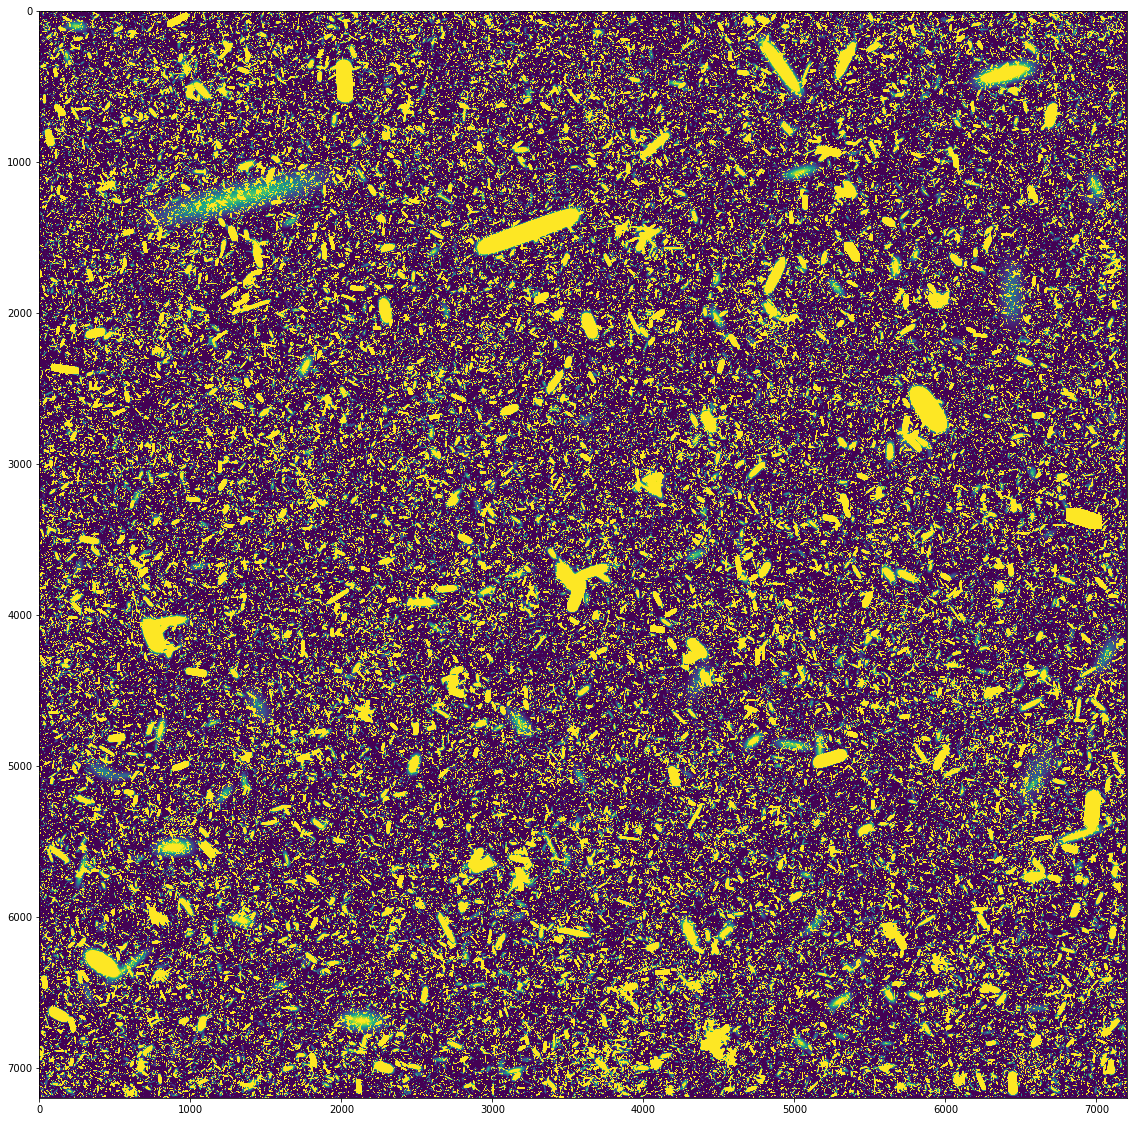

In [21]:
plt.figure(figsize=[20, 20])
plt.imshow(img_fr1_4deg, vmin=1e-11, vmax=1e-8)

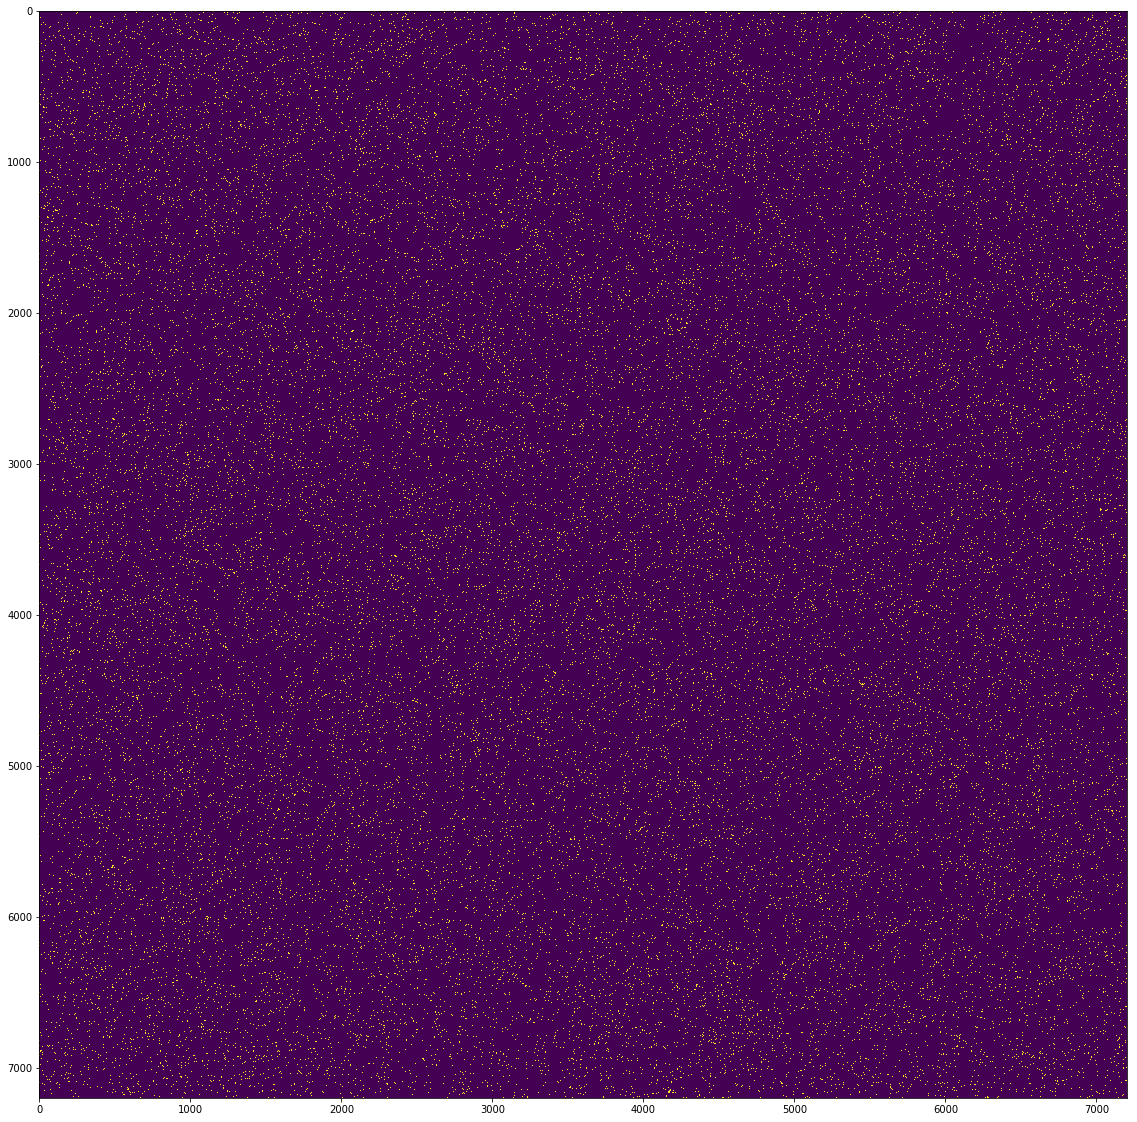

In [26]:
plt.figure(figsize=[20, 20])
plt.imshow(img_rq_4deg, vmin=1e-11, vmax=1e-8)

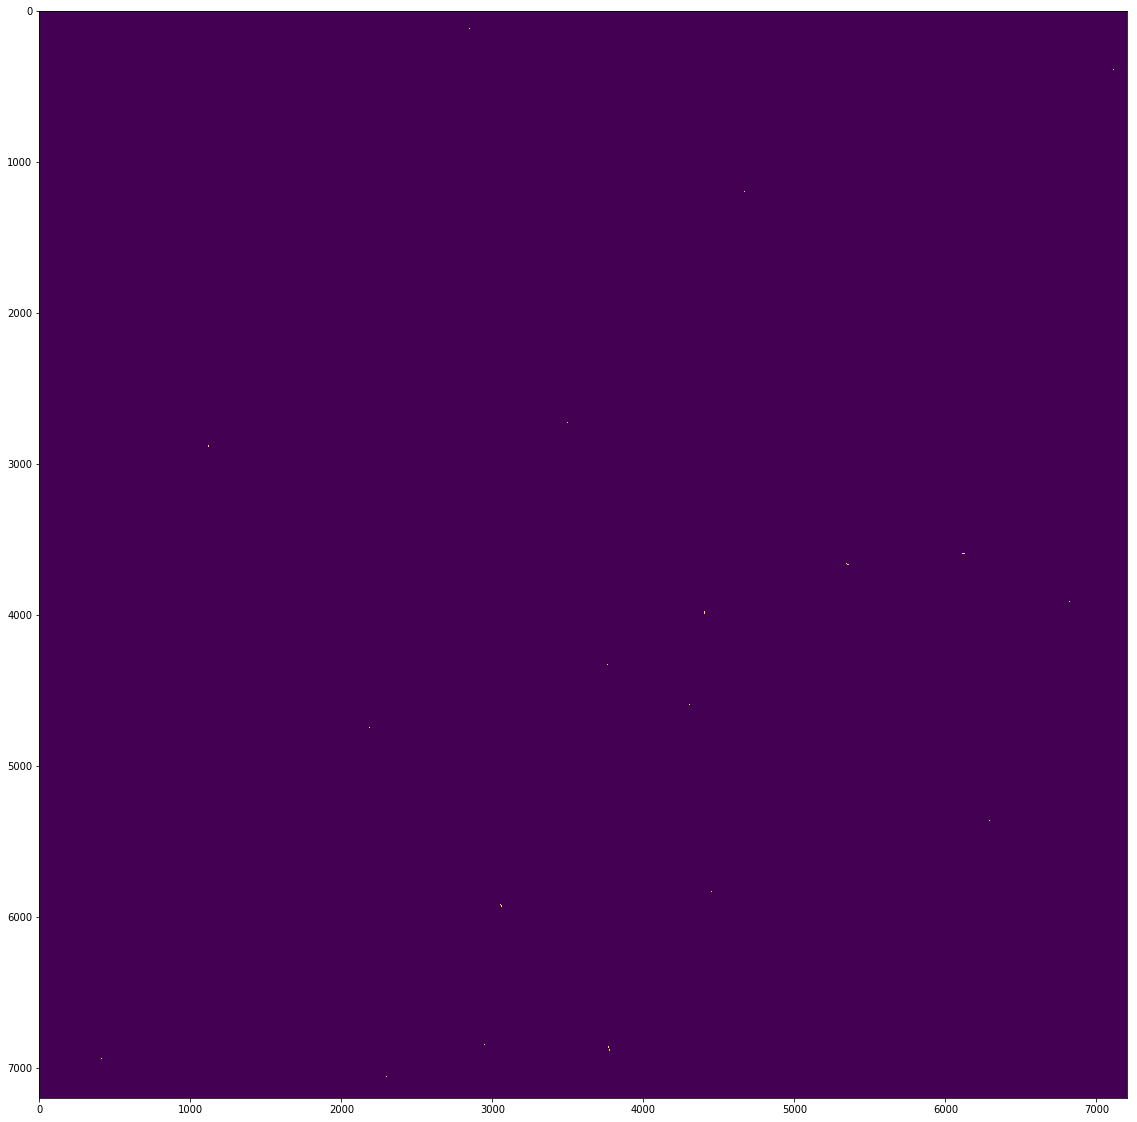

In [29]:
plt.figure(figsize=[20, 20])
plt.imshow(img_fr2_4deg, vmin=1e-11, vmax=1e-8)

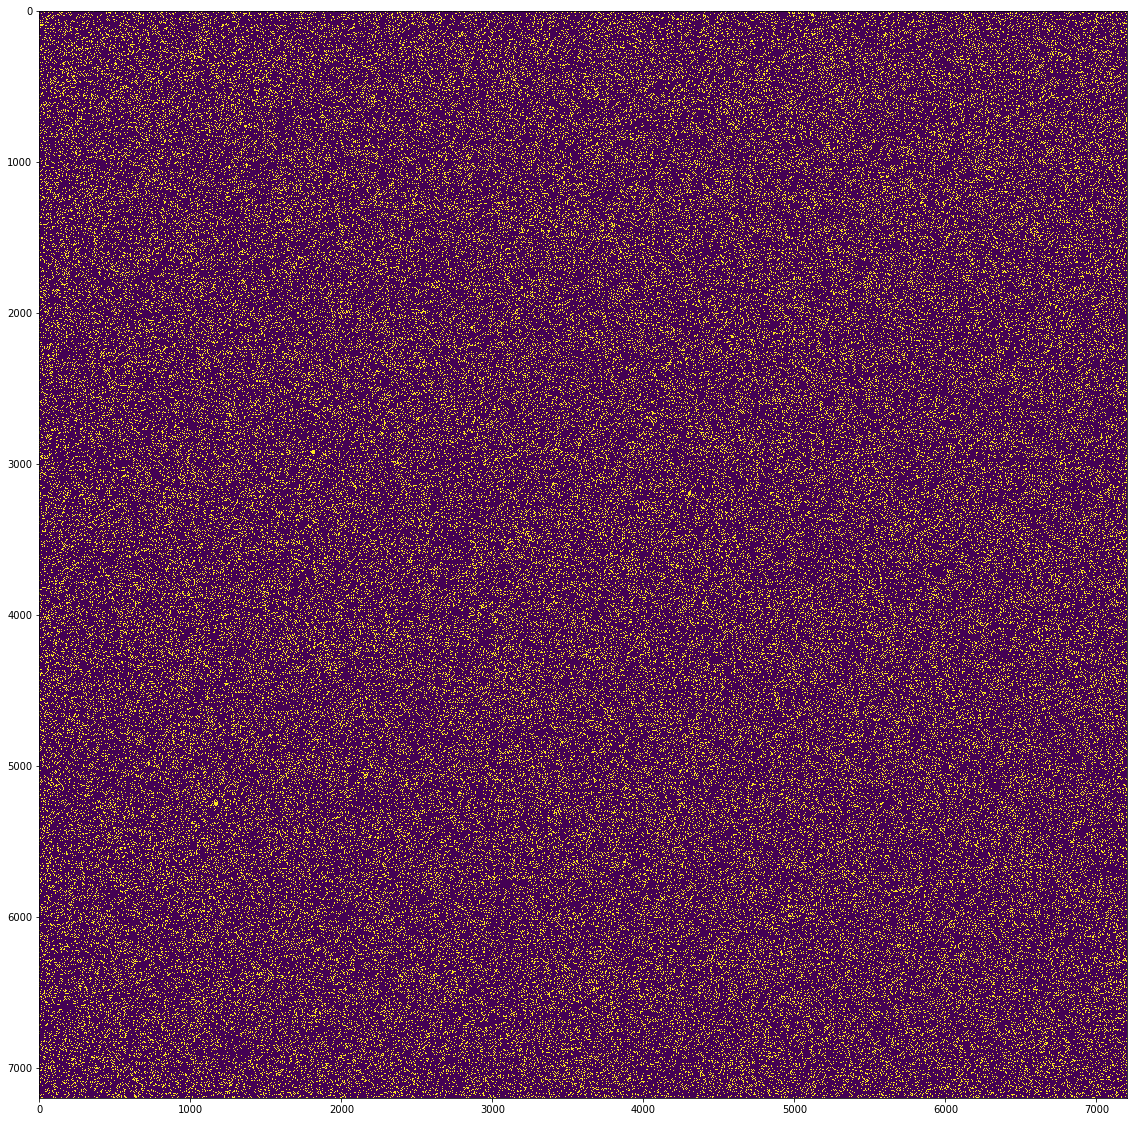

In [30]:
plt.figure(figsize=[20, 20])
plt.imshow(img_sf_4deg, vmin=1e-11, vmax=1e-8)

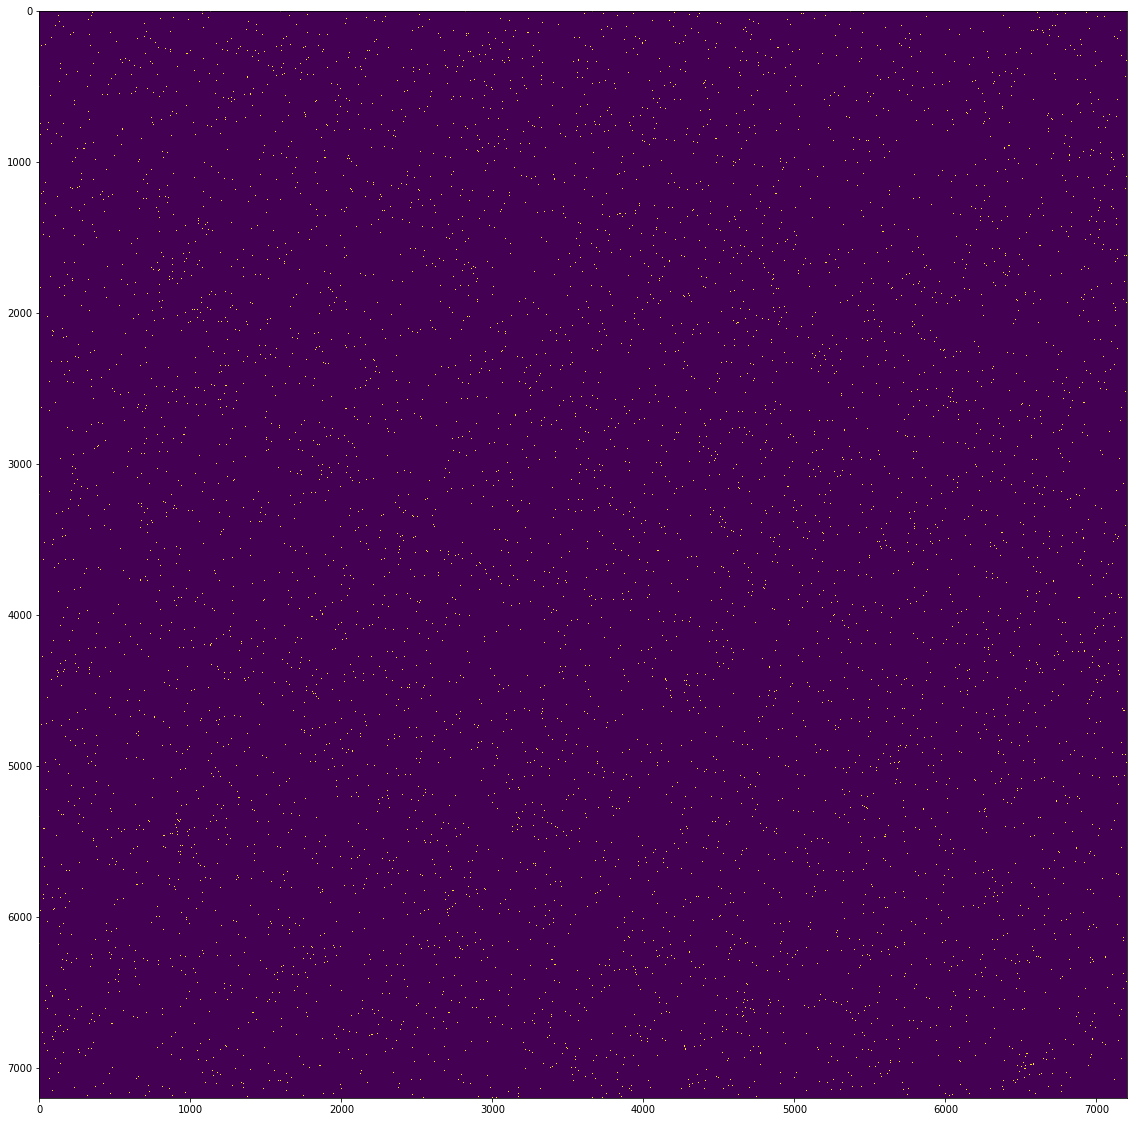

In [31]:
plt.figure(figsize=[20, 20])
plt.imshow(img_sb_4deg, vmin=1e-11, vmax=1e-8)

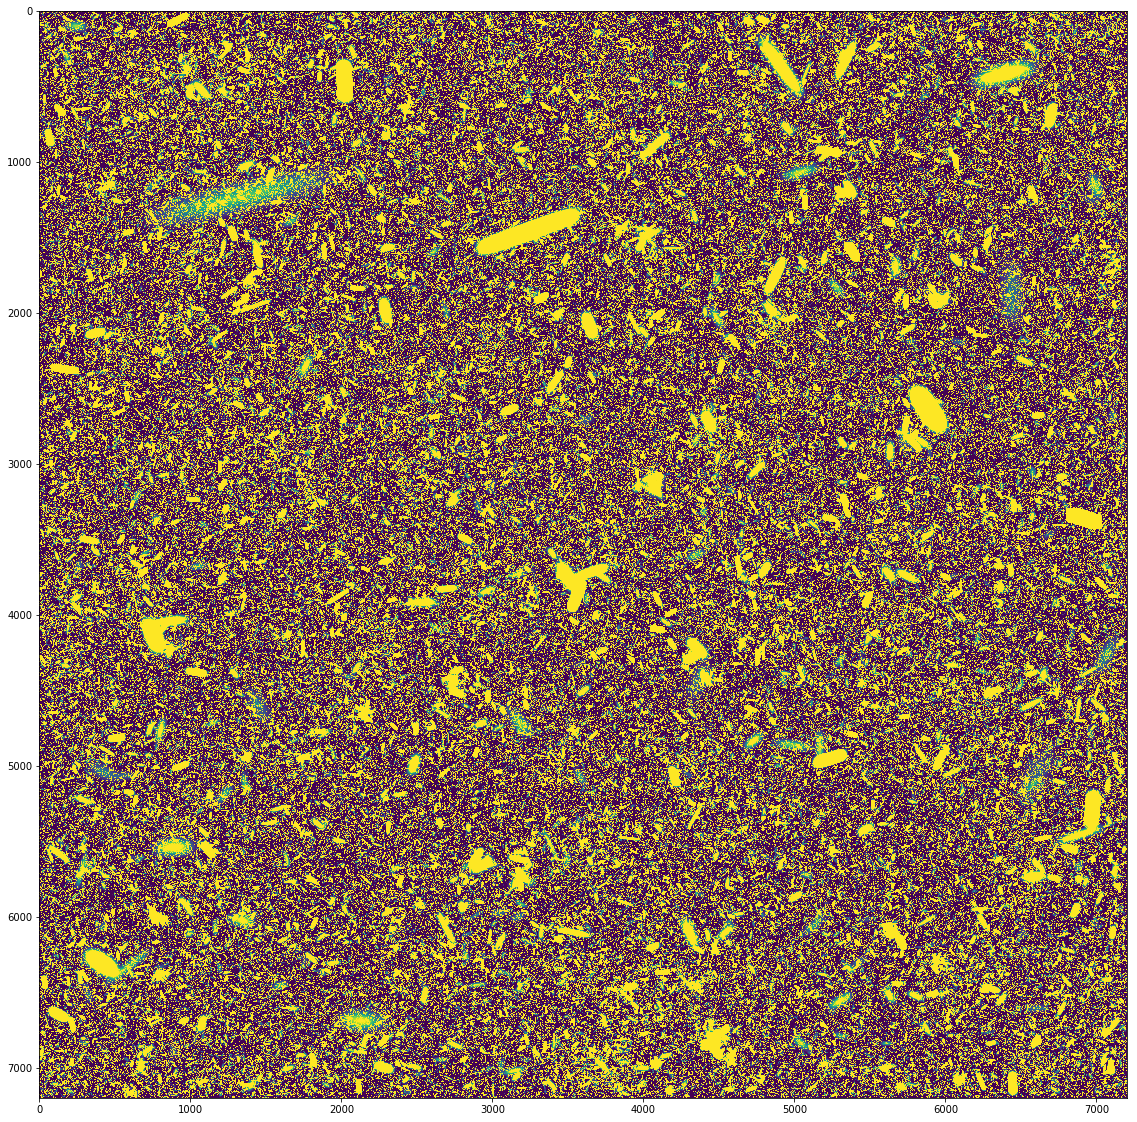

In [32]:
plt.figure(figsize=[20, 20])
plt.imshow(img_fr1_4deg+img_fr2_4deg+img_rq_4deg+img_sf_4deg+img_sb_4deg, vmin=1e-11, vmax=1e-8)